# COGS 108 - Final Project

# Group Members

- A12773207

- A12861347

- A12722694 

- A12602591

- A13783252 

- A14150876


# Introduction and Background:

For our final project, we aim to use “The Movies Dataset - movies_metadata.csv” and “The Movies Dataset - credits.csv” on Kaggle to generate a predictive model that will accurately predict the success of a movie. Our research question is of interest due to the pervasiveness of the film industry across cultures and our group members’ resulting affinity for films. After examining our chosen dataset, we decided to use budget, popularity (ranking), release date (month of release), revenue, and vote count as variables to determine a movie’s success. Before manipulating the data, we hypothesized that these variables would have an impact on the success of a movie, with budget being the most impactful. We defined the success of movies by the revenue relative to budget, and in order to control for factors like inflation and currency differences converted all values to 2019 USD. 
	
Before approaching this question, we conducted online research to see what studies had been done already in this field. We found two articles related to our project: a paper titled Predicting Movie Success Based on IMDb Data and a study titled A Predictor for Movie Success. 

The first paper was presented at the International Journal of Data Mining Techniques and Applications Conference. It details the process and results of a data analysis using logistic regression, SVM regression and linear regression on IMDB data to predict movie box office success. Authors hoped to make advertising campaign cost-effective using their model and they found that their results were in-line with other predictive models but not adequate for industry use, indicating that a larger data set would improve the performance of the model. 

The second study was conducted by Ericson and Grodman at Stanford University. They aimed to use machine learning to determine which factors and what interactions between those factors led to a movie’s success. This study measured success only by looking at factors that could be determined prior to a movie’s debut from sources like IMDB, Rotten Tomatoes, and Wikipedia. After computation, they achieved classification rates above 0.5 for each of their output features. The study provided insight into what makes a movie successful. 

Because our research question heavily overlaps with the two studies, after reading the two articles we also decided to use a linear regression model as a tool to predict a movie’s success inspired by the first paper. We also planned to merge data from “The Movies Dataset - movies_metadata.csv” and “The Movies Dataset - credits.csv” following Ericson and Grodman’s example to create a model that can predict the success of a movie with features we are interested in.  
    
References: 
Predicting Movie Success Based on IMDb Data - Nithin VR et. al.
https://www.researchgate.net/publication/282133920_Predicting_Movie_Success_Based_on_IMDB_Data)
A Predictor for Movie Success - Ericson and Grodman 
http://cs229.stanford.edu/proj2013/EricsonGrodman-APredictorForMovieSuccess.pdf)


# Data Description:

For this project, we decided to merge two datasets together in order to extract the features we wanted. 

Dataset Name: The Movies Dataset - movies_metadata.csv
https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv
Number of observations: 45.5k rows, 24 columns 
Description: 
This dataset contains metadata for all movies (release date, budget, revenue, genre, popularity, etc.) in the movies_metadata.csv file.

Dataset Name: The Movies Dataset - credits.csv Link to the Dataset:
https://www.kaggle.com/rounakbanik/the-movies-dataset#credits.csv
Number of Observations: 45.5k rows, 3 columns
Description: 
This dataset contains cast and crew Information in the credits.csv file.

We plan to first combine these two datasets into one, drop the rows with missing values, then compare all the movies with high revenue and high ratings/votes to see what they have in common. 


In [0]:
#Here are the imports we are using

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chisquare, normaltest

import patsy
import statsmodels.api as sm


In [0]:
#Load in our dataset

df = pd.read_csv("movies_metadata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

We retrieved some basic info about the dataset to get our bearings. Previewing the data shows we might have to deal with the data types for some of the variables and some columns we may not need.

In [0]:
# identify data types for each variable
print(df.dtypes)

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object


In the cell above we see that there are some columns we don't need, some columns whose datatypes make manipulation harder for us, and observations which don't fit within our year range of 2000 - 2020.
So we need to:
* Filter out data, so that our dataframe only contains movies that were released between 2000 and 2020
* Change columns such as id, popularity, and budget to be floats
* Remove adult, runtime, belongs_to_collection, homepage, imbd_id, poster_path, vote_average, tagline, vote_average, etc as we aren't going to use them in our analysis

In [0]:
#Filter release dates so that they are between January 1, 2000 and January 1, 2020.
df = df[(df['release_date'] > '2000-1-1') & (df['release_date'] <= '2020-1-1')]

#Setup the columns we want as floats and the columns we want to drop.
float_types = ['id', 'popularity', 'budget']
dropped_columns = ['adult', 'runtime', 'homepage', 'belongs_to_collection', 'imdb_id', 'poster_path', 'vote_average', 'tagline', 'spoken_languages', 'original_language', 'production_companies', 'production_countries']

for column in float_types:
    df[column] = df[column].astype(float)


df.drop(dropped_columns, axis=1, inplace=True)

For further analysis we add new columns with the month and year extracted from the release_date column. To do so we also then have to change the type of the release_date column to a datetime type for extraction.

In [0]:
df['release_date'] = pd.to_datetime(df['release_date'])

df['month_released'] = df['release_date'].dt.month
df['year_released'] = df['release_date'].dt.year

Here we see that our datatypes are now changed, and the columns are now removed. However, we now see that there are still some issues, namely that there are some empty entries for revenues and budgets which we mainly use in our analysis.

In [0]:
print(df.dtypes)
df.head(50)


budget                   float64
genres                    object
id                       float64
original_title            object
overview                  object
popularity               float64
release_date      datetime64[ns]
revenue                  float64
status                    object
title                     object
video                     object
vote_count               float64
month_released             int64
year_released              int64
dtype: object


,budget,genres,id,original_title,overview,popularity,release_date,revenue,status,title,video,vote_count,month_released,year_released
707,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",131232.0,Due Amici,"Two Sicilian friends, Nunzio and Pino, share t...",0.003949,2002-03-20,0.0,Released,Two Friends,False,0.0,3,2002
868,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",79782.0,Wenecja,An atmospheric coming-of-age story featuring a...,0.147130,2010-05-25,0.0,Released,Venice,False,4.0,5,2010
1081,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",141210.0,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,2013-10-12,0.0,Released,The Sleepover,False,1.0,10,2013
2114,0.0,"[{'id': 18, 'name': 'Drama'}]",143750.0,The Farmer's Wife,"As her surroundings are invaded by outsiders, ...",0.211754,2012-06-20,0.0,Released,The Farmer's Wife,False,1.0,6,2012
2564,0.0,"[{'id': 99, 'name': 'Documentary'}]",84198.0,A Place at the Table,"Using personal stories, this powerful document...",0.501046,2012-03-22,0.0,Released,A Place at the Table,False,7.0,3,2012
2778,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",171982.0,Romance,She's as hot as Britney Spears. Hotter. She pa...,0.052377,2012-10-09,0.0,Released,Romance,False,0.0,10,2012
3235,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",73642.0,The Closer You Get,Irish bachelors take out an ad in the Miami He...,0.427125,2000-12-27,0.0,Released,The Closer You Get,False,2.0,12,2000
3441,10000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",9456.0,The Crow: Salvation,Alex Corvis returns to the world of the living...,6.311201,2000-10-31,0.0,Released,The Crow: Salvation,False,74.0,10,2000
3818,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",24664.0,Bamboozled,TV producer Pierre Delacroix (Damon Wayans) be...,4.380258,2000-10-06,0.0,Released,Bamboozled,False,24.0,10,2000
3819,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",21370.0,Bootmen,Sean Odkin loves to dance much to his fathers ...,1.400650,2000-10-05,0.0,Released,Bootmen,False,7.0,10,2000


With this next cell we remove those observations which do not have both a budget and a revenue recorded, and we are left with 3,320 observations for our analysis.

In [0]:
df = df.loc[(df['budget'] != 0) & (df['revenue'] != 0)]


In [0]:
df.head(50)

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,spoken_languages,status,title,video,vote_count,month_released,year_released
3821,63600000.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",10461.0,en,Get Carter,Remake of the Michael Caine classic. Jack Cart...,6.047757,"[{'name': 'Franchise Pictures', 'id': 1403}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-06,19412993.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Get Carter,False,147.0,10,2000
3823,55000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",1597.0,en,Meet the Parents,"Greg Focker is ready to marry his girlfriend, ...",14.178281,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-06,330444045.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Meet the Parents,False,1743.0,10,2000
3824,4500000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",641.0,en,Requiem for a Dream,The hopes and dreams of four ambitious people ...,6.874828,"[{'name': 'Artisan Entertainment', 'id': 2188}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-27,7390108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Requiem for a Dream,False,2525.0,10,2000
3830,24000000.0,"[{'id': 35, 'name': 'Comedy'}]",16888.0,en,The Ladies Man,"Because of his salacious language, late-night ...",3.755409,"[{'name': 'SNL Studios', 'id': 2822}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-13,13700000.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Ladies Man,False,35.0,10,2000
3843,48000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 35, 'na...",1636.0,en,Bedazzled,"Elliot Richardson, suicidal techno geek, is gi...",8.781588,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-19,90383208.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Bedazzled,False,526.0,10,2000
3844,40000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",10647.0,en,Pay It Forward,"Like some other kids, 12-year-old Trevor McKin...",10.479723,"[{'name': 'Bel Air Entertainment', 'id': 788},...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-12,55707411.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pay It Forward,False,447.0,10,2000
3849,22000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 27, '...",24100.0,en,The Little Vampire,"Based on the popular books, the story tells of...",9.418340,"[{'name': 'New Line Cinema', 'id': 12}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2000-10-27,13555988.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Little Vampire,False,79.0,10,2000
3852,92000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",4327.0,en,Charlie's Angels,Aspects of this take on the 1970s hit TV serie...,9.774985,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-02,264105545.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Charlie's Angels,False,1253.0,11,2000
3853,80000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",4958.0,en,The Legend of Bagger Vance,World War I has left golfer Rannulph Junuh a p...,9.034884,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-02,39459427.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend of Bagger Vance,False,259.0,11,2000
3856,80000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",8870.0,en,Red Planet,Astronauts search for solutions to save a dyin...,8.534176,"[{'name': 'Village Roadshow Pictures', 'id': 7...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2000-11-10,33463969.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Red Planet,False,271.0,11,2000


With the following cell we create a dictionary that stores the appropriate inflation coefficients to convert the years 2000-2018 in 2019 dollars.

In [0]:
inflationDict = {'2018': 1.002,
'2017': 1.027,
'2016': 1.049,
'2015': 1.062,
'2014': 1.063,
'2013': 1.081,
'2012': 1.096,
'2011': 1.119,
'2010': 1.154,
'2009': 1.173,
'2008': 1.169,
'2007': 1.214,
'2006': 1.249,
'2005': 1.289,
'2004': 1.333,
'2003': 1.368,
'2002': 1.399,
'2001': 1.422,
'2000': 1.462}
print(inflationDict)
print(inflationDict.get("2000"))

{'2018': 1.002, '2017': 1.027, '2016': 1.049, '2015': 1.062, '2014': 1.063, '2013': 1.081, '2012': 1.096, '2011': 1.119, '2010': 1.154, '2009': 1.173, '2008': 1.169, '2007': 1.214, '2006': 1.249, '2005': 1.289, '2004': 1.333, '2003': 1.368, '2002': 1.399, '2001': 1.422, '2000': 1.462}
1.462


In [0]:
# YOUR CODE HERE
def inflation_ratio(year):
    
    if year == 2000:
        output = inflationDict.get('2000')
    elif year == 2001:
        output = inflationDict.get('2001')
    elif year == 2002:
        output = inflationDict.get('2002')
    elif year == 2003:
        output = inflationDict.get('2003')
    elif year == 2004:
        output = inflationDict.get('2004')
    elif year == 2005:
        output = inflationDict.get('2005')
    elif year == 2006:
        output = inflationDict.get('2006')
    elif year == 2007:
        output = inflationDict.get('2007')
    elif year == 2008:
        output = inflationDict.get('2008')
    elif year == 2009:
        output = inflationDict.get('2009')
    elif year == 2010:
        output = inflationDict.get('2010')
    elif year == 2011:
        output = inflationDict.get('2011')
    elif year == 2012:
        output = inflationDict.get('2012')
    elif year == 2013:
        output = inflationDict.get('2013')
    elif year == 2014:
        output = inflationDict.get('2014')
    elif year == 2015:
        output = inflationDict.get('2015')
    elif year == 2016:
        output = inflationDict.get('2016')
    elif year == 2017:
        output = inflationDict.get('2017')
    elif year == 2018:
        output = inflationDict.get('2018')
    return output

In [0]:
df["inflation_ratio"] = df["year_released"].apply(inflation_ratio)


In [0]:
df['adjusted_budget'] = df['budget'] * df['inflation_ratio']
df['adjusted_revenue'] = df['revenue'] * df['inflation_ratio']

In [0]:
df['genres'].isnull().values.any()

False

Creating two new columns to the dataframe, adjusted revenue and adjusted budget

In [0]:
df.head(50)

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,...,spoken_languages,status,title,video,vote_count,month_released,year_released,inflation_ratio,adjusted_budget,adjusted_revenue
3821,63600000.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",10461.0,en,Get Carter,Remake of the Michael Caine classic. Jack Cart...,6.047757,"[{'name': 'Franchise Pictures', 'id': 1403}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-06,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Get Carter,False,147.0,10,2000,1.462,92983200.0,2.838180e+07
3823,55000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",1597.0,en,Meet the Parents,"Greg Focker is ready to marry his girlfriend, ...",14.178281,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-06,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Meet the Parents,False,1743.0,10,2000,1.462,80410000.0,4.831092e+08
3824,4500000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",641.0,en,Requiem for a Dream,The hopes and dreams of four ambitious people ...,6.874828,"[{'name': 'Artisan Entertainment', 'id': 2188}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-27,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Requiem for a Dream,False,2525.0,10,2000,1.462,6579000.0,1.080434e+07
3830,24000000.0,"[{'id': 35, 'name': 'Comedy'}]",16888.0,en,The Ladies Man,"Because of his salacious language, late-night ...",3.755409,"[{'name': 'SNL Studios', 'id': 2822}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-13,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Ladies Man,False,35.0,10,2000,1.462,35088000.0,2.002940e+07
3843,48000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 35, 'na...",1636.0,en,Bedazzled,"Elliot Richardson, suicidal techno geek, is gi...",8.781588,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-19,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Bedazzled,False,526.0,10,2000,1.462,70176000.0,1.321403e+08
3844,40000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",10647.0,en,Pay It Forward,"Like some other kids, 12-year-old Trevor McKin...",10.479723,"[{'name': 'Bel Air Entertainment', 'id': 788},...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-10-12,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pay It Forward,False,447.0,10,2000,1.462,58480000.0,8.144423e+07
3849,22000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 27, '...",24100.0,en,The Little Vampire,"Based on the popular books, the story tells of...",9.418340,"[{'name': 'New Line Cinema', 'id': 12}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2000-10-27,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Little Vampire,False,79.0,10,2000,1.462,32164000.0,1.981885e+07
3852,92000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",4327.0,en,Charlie's Angels,Aspects of this take on the 1970s hit TV serie...,9.774985,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-02,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Charlie's Angels,False,1253.0,11,2000,1.462,134504000.0,3.861223e+08
3853,80000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",4958.0,en,The Legend of Bagger Vance,World War I has left golfer Rannulph Junuh a p...,9.034884,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-02,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend of Bagger Vance,False,259.0,11,2000,1.462,116960000.0,5.768968e+07
3856,80000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",8870.0,en,Red Planet,Astronauts search for solutions to save a dyin...,8.534176,"[{'name': 'Village Roadshow Pictures', 'id': 7...","[{'iso_3166_1': 'AU', 'name': '

# Data Visualization

After we have cleaned our data, our next step is to do some preliminary data visualization in order to explore what the data actually looks like. We can start by creating a scatter matrix, which contains pair-wise scatter plots of multiple variables within the dataset. 

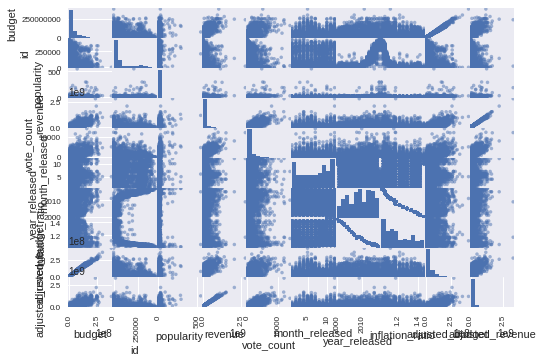

In [0]:
pd.plotting.scatter_matrix(df)
fig = plt.gcf()

In the scatter matrix plot above, we see that some variables have correlational relationships with other variables, and some do not. We want to further explore relationships between variables that are correlated, and we can do that with more data visualization techniques. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Adjusted Revenue')

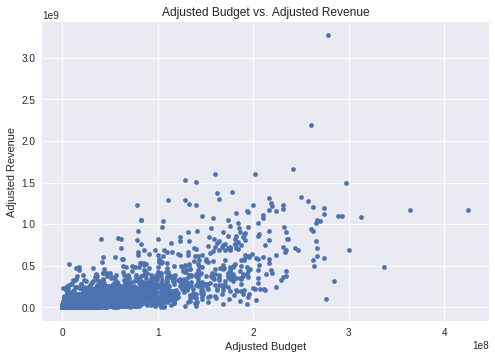

In [0]:
df.plot(kind = 'scatter', x='adjusted_budget', y='adjusted_revenue')
plt.title("Adjusted Budget vs. Adjusted Revenue")
plt.xlabel("Adjusted Budget")
plt.ylabel("Adjusted Revenue")


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Popularity')

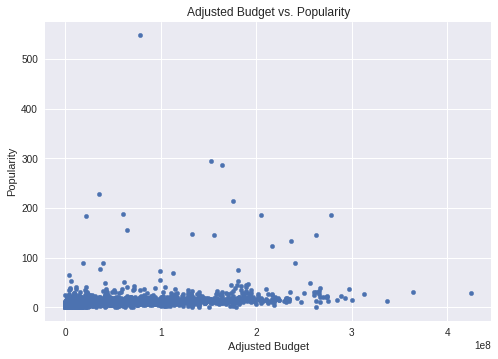

In [0]:
df.plot(kind = 'scatter', x = 'adjusted_budget', y = 'popularity')
plt.title("Adjusted Budget vs. Popularity")
plt.xlabel("Adjusted Budget")
plt.ylabel("Popularity")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Vote Count')

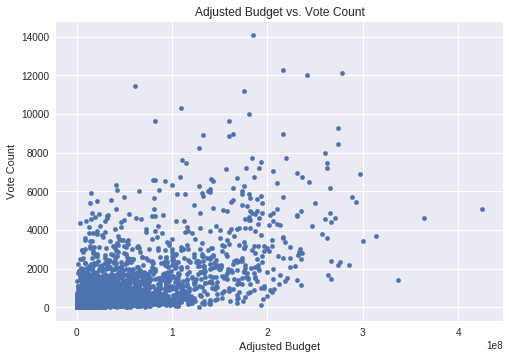

In [0]:
df.plot(kind = 'scatter', x='adjusted_budget', y ='vote_count')
plt.title("Adjusted Budget vs. Vote Count")
plt.xlabel("Adjusted Budget")
plt.ylabel("Vote Count")

As we can see from the scatter plots above, there is a strong positive correlation between budget and revenue, and a less strong positive correlation between budget and vote count. This may mean that an increased budget leads to more exposure. However, there was no correlation between budget and popularity, signaling that a higher budget may not have a strong impact on how popular a movie is. 

Next, we can look at possible correlations between the month of release and the success of the movie in terms of variables like budget, revenue and popularity. We will use the month_released column that we created previously. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe54503fd30>]],
      dtype=object)

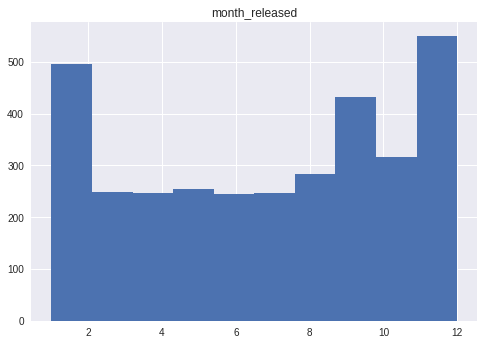

In [0]:
df.hist(column = 'month_released')

From the graph above, we see that a large proportion of movies are released at the very beginning of the year (January_ nad at the very end of the year (December), with a peak around November. Now, let's see if there are correlations between this variable and others in our dataset.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Adjusted Revenue')

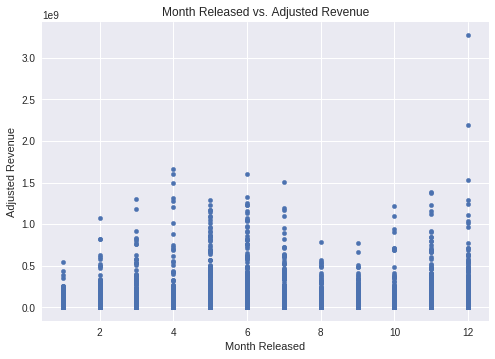

In [0]:
df.plot(kind = 'scatter', x = 'month_released', y='adjusted_revenue')
plt.title('Month Released vs. Adjusted Revenue')
plt.xlabel('Month Released')
plt.ylabel('Adjusted Revenue')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Popularity')

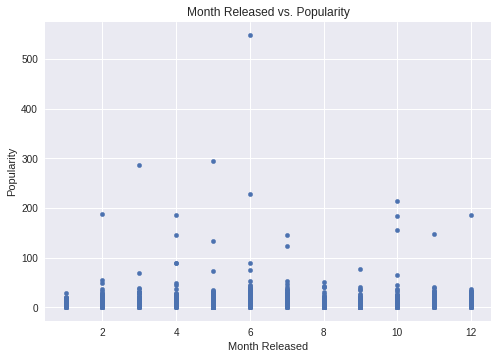

In [0]:
df.plot(kind = 'scatter', x='month_released', y ='popularity')
plt.title('Month Released vs. Popularity')
plt.xlabel('Month Released')
plt.ylabel('Popularity')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Adjusted Budget')

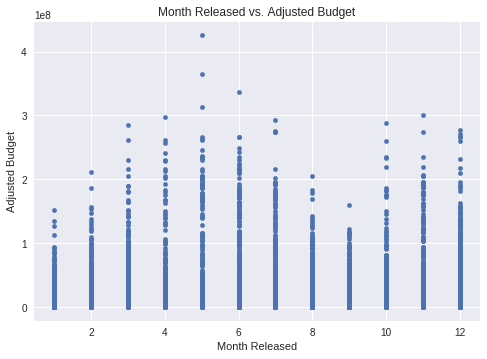

In [0]:
df.plot(kind = 'scatter', x='month_released', y='adjusted_budget')
plt.title('Month Released vs. Adjusted Budget')
plt.xlabel('Month Released')
plt.ylabel('Adjusted Budget')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Vote Count')

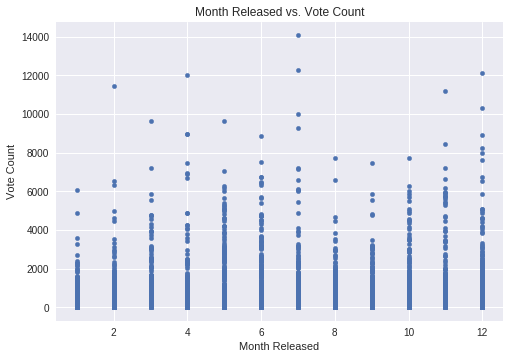

In [0]:
df.plot(kind = 'scatter', x='month_released', y='vote_count')
plt.title('Month Released vs. Vote Count')
plt.xlabel('Month Released')
plt.ylabel('Vote Count')

From the scatter plots above, we can see that the month of the release is most highly correlated with the budget, with a peak in during the spring. However, the month of release was least correlated with popularity. This demonstrates a surprising fact that the popularity of a movie does not necessarily correlate with its month of release or its budget. 

# Data Analysis and Results

Below, we explore the data to determine if it is normally distributed or not. This cell analyzes the time of year (month) and budget values for movies.


In [0]:
# month vs. budget values for movies released in first half
# or second half of year
h_mb1 = df[df['month_released'] <= 6]['budget'].values
h_mb2 = df[df['month_released'] > 6]['budget'].values

# calculate values to decide normalcy
st_mb1, p_mb1 = normaltest(h_mb1)
st_mb2, p_mb2 = normaltest(h_mb2)

# decide if the values are normal
if(p_mb1 < 0.05):
    is_n_mb1 = False
else:
    is_n_mb1 = True
    
if(p_mb2 < 0.05):
    is_n_mb2 = False
else:
    is_n_mb2 = True

if(is_n_mb1 == True):
    print("For movies released in the first half of the year, we found that the" +
          " data distribution was normal.")
elif(is_n_mb1 == False):
    print("For movies released in the first half of the year, we found that the" +
          " data distribution was NOT normal.")
    
if(is_n_mb2 == True):
    print("For movies released in the second half of the year, we found that the" + 
          " data distribution was normal.")
elif(is_n_mb2 == False):
    print("For movies released in the second half of the year, we found that the" +
          " data distribution was NOT normal.")

For movies released in the first half of the year, we found that the data distribution was NOT normal.
For movies released in the second half of the year, we found that the data distribution was NOT normal.


Below, we explore the data to determine if it is normally distributed or not. This cell analyzes the vote count and budget values for movies.

In [0]:
# vote count vs. budget
avg_vote = df['vote_count'].mean()
h_under_vb = df[df['vote_count'] <= avg_vote]['budget'].values
h_over_vb = df[df['vote_count'] > avg_vote]['budget'].values

# calculate values to decide normalcy
st_vb1, p_vb1 = normaltest(h_under_vb)
st_vb2, p_vb2 = normaltest(h_over_vb)

# decide if the values are normal
if(p_vb1 < 0.05):
    is_n_vb1 = False
else:
    is_n_vb1 = True
    
if(p_vb2 < 0.05):
    is_n_vb2 = False
else:
    is_n_vb2 = True

if(is_n_vb1 == True):
    print("For movies with vote counts under average, we found that the data distribution was normal.")
elif(is_n_vb1 == False):
    print("For movies with vote counts under average, we found that the data distribution was NOT normal.")
    
if(is_n_vb2 == True):
    print("For movies with vote counts over average, we found that the data distribution was normal.")
elif(is_n_vb2 == False):
    print("For movies with vote counts over average, we found that the data distribution was NOT normal.")

Below, we explore the data to determine if it is normally distributed or not. This cell analyzes the revenue and budget values for movies.

In [0]:
# revenue vs. budget
avg_rev = df['revenue'].mean()
h_under_rb = df[df['revenue'] <= avg_rev]['budget'].values
h_over_rb = df[df['revenue'] > avg_rev]['budget'].values

# calculate values to decide normalcy
st_rb1, p_rb1 = normaltest(h_under_rb)
st_rb2, p_rb2 = normaltest(h_over_rb)

# decide if the values are normal
if(p_rb1 < 0.05):
    is_n_rb1 = False
else:
    is_n_rb1 = True
    
if(p_rb2 < 0.05):
    is_n_rb2 = False
else:
    is_n_rb2 = True

if(is_n_rb1 == True):
    print("For movies with revenues under average, we found that the data distribution was normal.")
elif(is_n_rb1 == False):
    print("For movies with revenues under average, we found that the data distribution was NOT normal.")
    
if(is_n_rb2 == True):
    print("For movies with revenues over average, we found that the data distribution was normal.")
elif(is_n_rb2 == False):
    print("For movies with revenues over average, we found that the data distribution was NOT normal.")

Because we found that the data distribution was not normal, we are able to then reject our null hypothesis,
or reject the hypothsis that there is no impact of these variables on a movie's budget. 


Next, in order to analyze the correlation of our variables on a movie's revenue, we can use a linear regression model and look at the r-squared value.

In [0]:
outcome_2, predictors_2 = patsy.dmatrices('adjusted_revenue ~ adjusted_budget + vote_count + popularity + month_released', df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:       adjusted_revenue   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     2381.
Date:                Fri, 15 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:07:22   Log-Likelihood:                -66239.
No. Observations:                3320   AIC:                         1.325e+05
Df Residuals:                    3315   BIC:                         1.325e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -3.47e+07   4.65e+06     

In the linear regression model table above, we can see that there is a relatively strong correlation (R-squred value of 0.742) between the adjust revenue of a movie and it's adjusted budget, vote count, popularity and month of release. This proves our hypothesis that these variables would have an impact on the revenue on a movie all together, even if separately their impact was relatively small. 

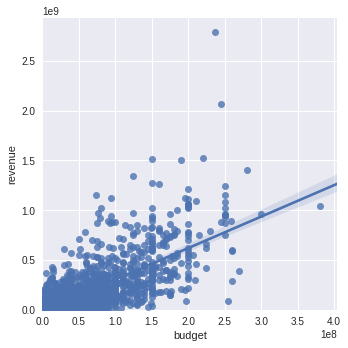

In [0]:
fig=sns.lmplot(x='budget',y='revenue',data=df,fit_reg=True) 
fig.set(xlim=(4, None))
fig.set(ylim=(4,None))
plt.show()

# Privacy and Ethics Considerations

This dataset was found on Kaggle, and it is considered in the public domain and therefore is available for copying, modifying, distributing, and performing all without requiring permission (even for commercial purposes). For our academic purposes, we have permission to use this dataset. The information contained in this dataset is completely public, and all of it can be found through a regular Google search. In accordance with the guidelines set by Safe Harbour regarding personal data, there are no indicators of any personal, non-public information in the data set, and any elements of the dataset that may have indicators of non-public data will not be used. Additionally, there are areas in this data set where the budget for the movie is not reported; any studio’s budget that had not previously been reported for a movie will remain unreported as the dataset will not be altered from the one posted publicly on Kaggle. 
    
Potential biases towards movies produced in the United States with an original language as English were present in the data, which we took into account in our analysis and controlled for variables such as monetary inflation and conversion rates. However, the data might still reflect a biased population due to a large portion of the audience with primary access to Hollywood and U.S.-produced movies. Finally, movies that were not produced in the United States or do not have their primary language as English were less likely to have all of their columns completely filled out; with many movies leaving their budget or cast unlisted. While we were not able to perfectly account for bias across the entirety of the dataset, due to these implicit biases, there are two ways in which we aimed to minimize them. The first way was through limiting the data that we focused on to only those with the data we required. We analyzed the dataset by separating them into decades and only analyzing movies produced within the last 20 years. In doing so, we are able to determine which variable had the most influence on movie success within a contemporary time frame. The second way is to create two new columns, called adjusted budget and adjusted revenue, that list the product between budget/revenue and a coefficient that converts the value into the US dollar in 2019. This allows us to control for variables such as differing currency values or inflation.


# Conclusions and Discussion

Since our initial project proposal, we changed some details while executing data In our initial project proposal, we planned to use budget, genre, release date and the production company as variables to create the prediction model. However, to simplify the data analysis process, we unified the type of data to numbers and changed our variables to budget, revenue, popularity (ranking on IMDB), audience vote count, and month released. 

Our exploration of the data and testing distributions revealed that our data was not normally distributed, allowing us to reject our null hypothesis, which stated that none of the variables in our dataset (budget, revenue, popularity, audience vote count, and month released) would impact the revenue. The linear regression model showed a 0.742 correlation between the variables of vote count, popularity, month of release and adjusted budget and the adjusted revenue. The scatterplots do not indicate a strong correlation, but the linear regression showed that there was a strong correlation between all of the variables and the adjusted budget. This correlation allows us to accept our original hypothesis which states that the variables in our dataset (budget, revenue, popularity, audience vote count, and month released) have an impact on the revenue of a movie. It should be noted that the significant impact was not found between each variable and the revenue separately, but between all the variables and the revenue together. 

However, potential pitfalls for our project include the fact that our dataset does not contain enough information about movies produced in foreign countries or foreign languages, making our model not applicable to all movies. And after further reflection on the intent behind such a predictor, we concluded an overly algorithmic approach to movie planning might discourage producers to take risks, and sometimes the least expected might turn out to be the most iconic movie. 
